Using features: ['signed_amount', 'tx_hour', 'tx_weekday', 'price_before', 'vol_before', 'vwap_before']
Missing features: []
[INFO] Paper trading log saved: ../data/paper_trading_log.csv

=== PAPER TRADING PERFORMANCE ===
Strategy mean abs return: 0.1156%
Baseline mean abs return: 0.0965%
Improvement: 0.0191%

=== PERFORMANCE PER STOCK ===
MSFT: mean=0.1156% | Δ=0.0191%


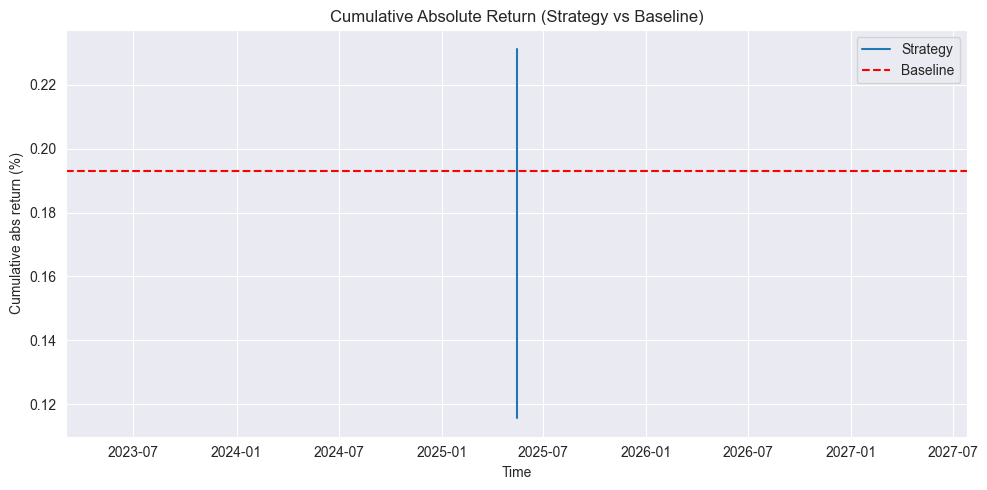

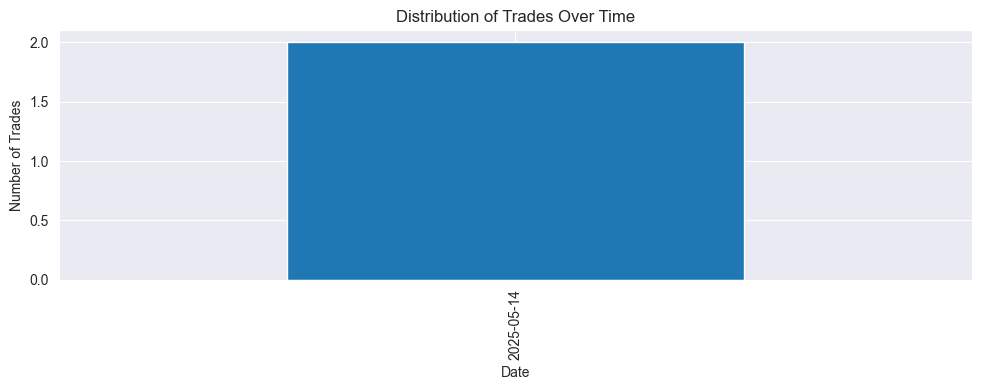

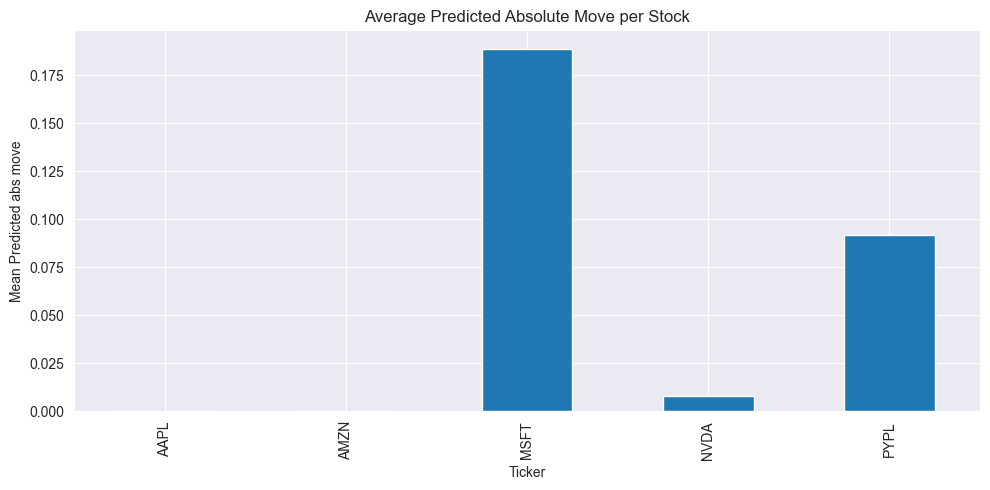

In [9]:
# 09_papertrade_senator.ipynb

import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Paths & Config

PATH_DATA = "../data/test_set_senator.parquet"  # Testset
PATH_MODEL = "models/senator_randomforest.pkl"
LOG_FILE = "../data/paper_trading_log.csv"
IMG_PATH = "../images"

os.makedirs(IMG_PATH, exist_ok=True)

# Trading settings
THRESHOLD_QUANTILE = 0.8  # top 20% predicted moves


# 2. Load model & test data

df = pd.read_parquet(PATH_DATA)
model = joblib.load(PATH_MODEL)

# Sort by timestamp
df['TimeOfFiled'] = pd.to_datetime(df['TimeOfFiled'])
df = df.sort_values('TimeOfFiled')

# Features used by the model
features = list(model.feature_names_in_)
print("Using features:", features)

# 3. Generate predictions & signals

# Check for missing features
missing = [f for f in features if f not in df.columns]
print("Missing features:", missing)

# For missing features, create them (like normalized signed_amount if missing)
if 'signed_amount' in missing:
    raise ValueError("signed_amount is missing! Cannot proceed.")
if 'tx_hour' not in df.columns:
    df['tx_hour'] = df['TimeOfFiled'].dt.hour
if 'tx_weekday' not in df.columns:
    df['tx_weekday'] = df['TimeOfFiled'].dt.weekday
if 'price_before' not in df.columns:
    raise ValueError("price_before is missing! Cannot proceed.")
if 'vol_before' not in df.columns:
    raise ValueError("vol_before is missing! Cannot proceed.")
if 'vwap_before' not in df.columns:
    df['vwap_before'] = df['price_before']  # fallback

# Generate predictions
df['predicted_abs_move'] = model.predict(df[features])

# Threshold-based trades
threshold = df['predicted_abs_move'].quantile(THRESHOLD_QUANTILE)
df['trade'] = df['predicted_abs_move'] > threshold


# 4. Simulate paper trading

results = []

for idx, row in df.iterrows():
    if row['trade']:
        results.append({
            "timestamp": row['TimeOfFiled'],
            "Ticker": row['Ticker'],
            "signal": "LONG",
            "predicted_abs_move": row['predicted_abs_move'],
            "realized_abs_move": row['price_change_pct']
        })
    else:
        results.append({
            "timestamp": row['TimeOfFiled'],
            "Ticker": row['Ticker'],
            "signal": "FLAT",
            "predicted_abs_move": row['predicted_abs_move'],
            "realized_abs_move": row['price_change_pct']
        })

# Save log
df_log = pd.DataFrame(results)
df_log.to_csv(LOG_FILE, index=False)
print(f"[INFO] Paper trading log saved: {LOG_FILE}")


# 5. Performance Analysis

strategy_returns = df_log[df_log['signal'] == 'LONG']['realized_abs_move']
baseline_return = df_log['realized_abs_move'].mean()

print("\n=== PAPER TRADING PERFORMANCE ===")
print(f"Strategy mean abs return: {strategy_returns.mean():.4f}%")
print(f"Baseline mean abs return: {baseline_return:.4f}%")
print(f"Improvement: {strategy_returns.mean() - baseline_return:.4f}%")

# Per stock performance
print("\n=== PERFORMANCE PER STOCK ===")
for ticker, g in df_log[df_log['signal'] == 'LONG'].groupby('Ticker'):
    mean_ret = g['realized_abs_move'].mean()
    improvement = mean_ret - baseline_return
    print(f"{ticker}: mean={mean_ret:.4f}% | Δ={improvement:.4f}%")


# 6. Plots

# 6a. Equity curve
df_eq = df_log[df_log['signal'] == 'LONG'].sort_values('timestamp')
df_eq['cum_return'] = df_eq['realized_abs_move'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(df_eq['timestamp'], df_eq['cum_return'], label='Strategy')
plt.axhline(baseline_return * len(df_eq), linestyle='--', color='red', label='Baseline')
plt.title("Cumulative Absolute Return (Strategy vs Baseline)")
plt.xlabel("Time")
plt.ylabel("Cumulative abs return (%)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_PATH}/09_paper_equity_curve.png", dpi=150)
plt.show()

# 6b. Trade distribution per day
plt.figure(figsize=(10,4))
df_log[df_log['signal']=='LONG']['timestamp'].dt.date.value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Trades Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.savefig(f"{IMG_PATH}/09_paper_trade_distribution.png", dpi=150)
plt.show()

# 6c. Average predicted move per stock
avg_pred = df_log.groupby("Ticker")["predicted_abs_move"].mean()
avg_pred.plot(kind="bar", figsize=(10,5))
plt.title("Average Predicted Absolute Move per Stock")
plt.ylabel("Mean Predicted abs move")
plt.tight_layout()
plt.savefig(f"{IMG_PATH}/09_paper_avg_pred.png", dpi=150)
plt.show()


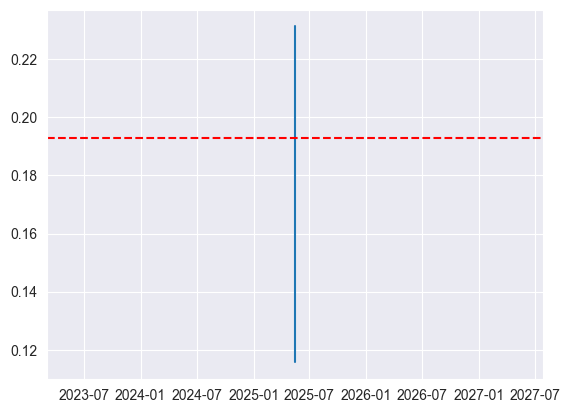

In [8]:
plt.plot(df_eq['timestamp'], df_eq['cum_return'], label='Strategy')
plt.axhline(baseline_return * len(df_eq), linestyle='--', color='red', label='Baseline')

